In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy
from numpy import zeros, asarray, unique, sqrt
from scipy.io import savemat
import madrigal
import datetime
from itertools import chain
import os
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import mpld3

In [3]:
mpld3.enable_notebook()

In [4]:
filepath = '../data/madrigal/isr/jro20050916_drifts.001'

In [5]:
column_names = madrigal.get_madrigal_column_names(filepath)
print(column_names)

['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'UT1_UNIX', 'UT2_UNIX', 'RECNO', 'RANGE', 'GDLATR', 'GDLONR', 'SPCST', 'PL', 'CBADN', 'INTTMS', 'AZDIR7', 'ELDIR7', 'AZDIR8', 'ELDIR8', 'JRO14', 'JRO15', 'JRO16', 'JRO17', 'GDALT', 'VIPN2', 'DVIPN2', 'VIPE1', 'DVIPE1', 'VI72', 'DVI72', 'VI82', 'DVI82', 'PAIWL', 'PACWL', 'PBIWL', 'PBCWL', 'PCIEL', 'PCCEL', 'PDIEL', 'PDCEL', '32000', '32001']


In [6]:
# parse data
data = madrigal.parse_madrigal_hdf5(filepath)

In [7]:
# process data into image
image = madrigal.create_2d_image(data, dtype='VIPN2')
altitude = madrigal.get_record_altitudes(data)
time = madrigal.get_record_datetimes(data)
print(image.shape, altitude.shape, len(time))

(60, 16860) (16860,) 16860


In [8]:
mpld3.disable_notebook()

In [9]:
# datetime utils
unix_epoch = datetime.datetime(1970, 1, 1, tzinfo=datetime.timezone.utc)
peru_timezone = datetime.timezone(datetime.timedelta(hours=-5))

In [10]:
# drift plot setup
advance_day = 0
unix_time = asarray([(t - unix_epoch).total_seconds() for t in time])
peru_day_start = datetime.datetime(time[0].year, time[0].month, time[0].day + advance_day, tzinfo=peru_timezone)
unix_day_start_offset = (peru_day_start - unix_epoch).total_seconds()
xticks = [0, 6 * 3600, 12 * 3600, 18 * 3600]
xticks = [unix_day_start_offset + tick for tick in xticks]
xtick_datetimes = [unix_epoch + datetime.timedelta(seconds=tick) for tick in xticks]
xtick_datetimes = [dt.astimezone(peru_timezone) for dt in xtick_datetimes]
xtick_labels = ['{hour:02}:{minute:02}'.format(hour=dt.hour, minute=dt.minute) for dt in xtick_datetimes]
xpad = [0, 0]

yticks = [ 200, 400, 600, 800]
ytick_labels = ['{0}'.format(alt) for alt in yticks]

extents = [numpy.min(unix_time), numpy.max(unix_time), numpy.min(altitude), numpy.max(altitude)]

image_min, image_max = -30, 30
_image = image.copy()
_image[numpy.logical_and(~numpy.isnan(_image), _image > image_max)] = image_max
_image[numpy.logical_and(~numpy.isnan(_image), _image < image_min)] = image_min

//anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater
//anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in less


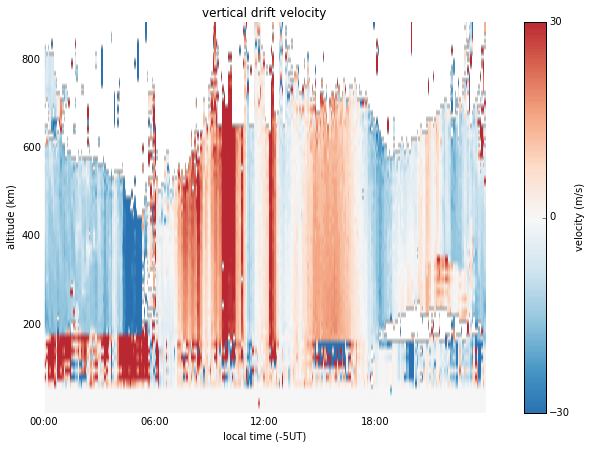

In [11]:
# drift plot
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
im = ax.imshow(_image, aspect='auto', origin='lower', extent=extents, cmap=cm.RdBu_r)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
cax = divider.append_axes('right', size='5%', pad=0.55)
cb = plt.colorbar(im, orientation='vertical', cax=cax)
cb.set_label('velocity (m/s)')
cb.set_clim(-40, 40)
cb.set_ticks([-30, 0, 30])
# cb.ax.set_ylim([cb.norm(-60), cb.norm(60)])
# cb.ax.set_aspect(60)
for tic in chain(ax.get_yaxis().get_major_ticks(), ax.get_xaxis().get_major_ticks()):
    tic.tick1On = tic.tick2On = False
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_ylabel('altitude (km)')
ax.set_xlabel('local time (-5UT)')
ax.set_title('vertical drift velocity')
fig.savefig('../figures/september_anomaly_vertical_image.png')

### Average Drift Plot

In [12]:
# filepath = '../data/madrigal/isr/jro20150324drifts_avg.001'
# filepath = '../data/madrigal/isr/jro20150325drifts_avg.001'
filepath = '../data/madrigal/isr/jro20050915_avg_drifts.001'

In [13]:
column_names = madrigal.get_madrigal_column_names(filepath)
print(column_names)
# parse data
data = madrigal.parse_madrigal_hdf5(filepath)

['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'UT1_UNIX', 'UT2_UNIX', 'RECNO', 'GDLATR', 'GDLONR', 'SPCST', 'PL', 'CBADN', 'INTTMS', 'RANGE', 'GDALT', 'ALTAV', 'VIPN2', 'DVIPN2', 'VIPE1', 'DVIPE1']


In [14]:
# get ave drift variables
image = madrigal.create_2d_image(data, dtype='VIPN2')
error = madrigal.create_2d_image(data, dtype='DVIPN2')
time = madrigal.get_record_datetimes(data, tzinfo=datetime.timezone.utc)
time = [t.astimezone(peru_timezone) for t in time]
time = [t.replace(year=time[0].year, month=time[0].month, day=time[0].day) for t in time]
altitude = madrigal.get_record_altitudes(data, validate=False)

In [15]:
# average image
decimate = 6
N = image.shape[1] // decimate
_image = image[:, :N * decimate]
_image = numpy.sum(_image.reshape((image.shape[0], image.shape[1] // decimate, decimate)), axis=2) / decimate
_error = error[:, :N * decimate]
_error = sqrt(numpy.sum(_error.reshape((error.shape[0], error.shape[1] // decimate, decimate))**2, axis=2)) / decimate
_time = time[:N*decimate:decimate]

In [16]:
altitude_bins = altitude[:7]
print(altitude_bins)

[ 247.  307.  367.  427.  487.  547.  397.]


In [17]:
# fix times
unix_epoch = datetime.datetime(1970, 1, 1, tzinfo=datetime.timezone.utc)
unix_time = asarray([(t - unix_epoch).total_seconds() for t in _time])

In [18]:
# set up ave drift plot
legend = False
level = 2
levels = [0, 1, 2, 3, 4, 5]
labels = ['{0:3} km'.format(height) for height in altitude_bins]
advance_day = 0
# colors = [(.6,.7,.8), (.3,.9,.9), (.7,.9,.4), (.7,.8,.6)]
colors = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1)]
advance_day = 0
peru_day_start = datetime.datetime(time[0].year, time[0].month, time[0].day + advance_day, tzinfo=peru_timezone)
unix_day_start_offset = (peru_day_start - unix_epoch).total_seconds()
xticks = [0, 6 * 3600, 12 * 3600, 18 * 3600, 24 * 3600]
# xticks = [0, 6 * 3600, 12 * 3600, 18 * 3600, 24 * 3600, 30 * 3600]
xticks = [unix_day_start_offset + tick for tick in xticks]
xtick_datetimes = [unix_epoch + datetime.timedelta(seconds=tick) for tick in xticks]
xtick_datetimes = [dt.astimezone(peru_timezone) for dt in xtick_datetimes]
xtick_labels = ['{hour:02}:{minute:02}'.format(hour=dt.hour, minute=dt.minute) for dt in xtick_datetimes]
xpad = [0, 0]
yticks = [-60, -30, 0, 30, 60]
ylim = [-80, 80]
# yticks = [-200, -100, 0, 100, 200]
# ylim = [-300, 300]
ytick_labels = yticks
title = 'Equinox (September) vertical drift velocity at {3} altitude'.format(peru_day_start.year, peru_day_start.month, peru_day_start.day, labels[level])

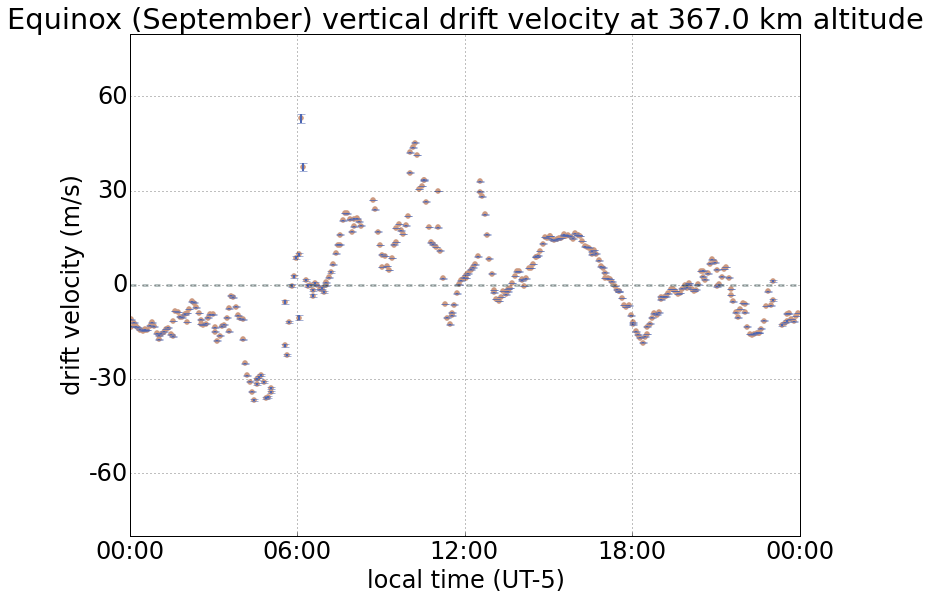

In [21]:
# ave drift plot
mpl.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
ax.errorbar(unix_time, _image[level, :], _error[level, :], fmt='none', elinewidth=2, capsize=4, 
                barsabove=True, ecolor=(.3,.4,.7), color=(.6,.9,.4))
ax.scatter(unix_time, _image[level, :], color=(.8,.6,.5))
# ax.plot(unix_time, _image[level, :], color=(.6,.7,.4,.4))
ax.plot([xticks[0], xticks[-1]], [0, 0], '--', color=(.3,.4,.4,.4), linewidth=3)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_xlim([xticks[0] + xpad[0], xticks[-1] + xpad[-1]])
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.set_ylim(ylim)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
for tic in ax.get_yaxis().get_major_ticks():
    tic.tick1On = tic.tick2On = False
if legend:
    ax.legend()
ax.set_xlabel('local time (UT-5)')
ax.set_ylabel('drift velocity (m/s)')
ax.set_title(title)
ax.grid(True)
fig.savefig('../figures/september_single_vertical.png')

.

.

.

.

### average drift plot seasonal

In [65]:
# pattern = re.compile('.*\d{4}(01)\d{2}_avg_drifts.*')
# pattern = re.compile('.*\d{4}(03)\d{2}_avg_drifts.*')
pattern = re.compile('.*\d{4}(06)\d{2}_avg_drifts.*')
# pattern = re.compile('.*\d{4}(09)\d{2}_avg_drifts.*')
filepaths = []
for filepath in os.listdir('../data/madrigal/isr/'):
    matches = pattern.match(filepath)
    if matches:
        filepaths.append('../data/madrigal/isr/' + filepath)

In [66]:
print(filepaths)

['../data/madrigal/isr/jro20020601_avg_drifts.001', '../data/madrigal/isr/jro20020602_avg_drifts.001', '../data/madrigal/isr/jro20020603_avg_drifts.001', '../data/madrigal/isr/jro20020604_avg_drifts.001', '../data/madrigal/isr/jro20020605_avg_drifts.001', '../data/madrigal/isr/jro20040608_avg_drifts.001', '../data/madrigal/isr/jro20040609_avg_drifts.001', '../data/madrigal/isr/jro20040610_avg_drifts.001', '../data/madrigal/isr/jro20040611_avg_drifts.001', '../data/madrigal/isr/jro20040614_avg_drifts.001', '../data/madrigal/isr/jro20040615_avg_drifts.001', '../data/madrigal/isr/jro20040616_avg_drifts.001', '../data/madrigal/isr/jro20040617_avg_drifts.001', '../data/madrigal/isr/jro20040618_avg_drifts.001', '../data/madrigal/isr/jro20040619_avg_drifts.001', '../data/madrigal/isr/jro20080603_avg_drifts.001', '../data/madrigal/isr/jro20080604_avg_drifts.001', '../data/madrigal/isr/jro20080605_avg_drifts.001', '../data/madrigal/isr/jro20080606_avg_drifts.001', '../data/madrigal/isr/jro20080

In [67]:
# filepaths = ['../data/madrigal/isr/jro20150',
#              '../data/madrigal/isr/jro20150324drifts_avg.001',
#              '../data/madrigal/isr/jro20150325drifts_avg.001',
#              '../data/madrigal/isr/jro20140331drifts_avg.001',
#              '../data/madrigal/isr/jro20130319drifts_avg.001',
#              '../data/madrigal/isr/jro20130320drifts_avg.001',
#              '../data/madrigal/isr/jro20130321drifts_avg.001',
#              ]

In [68]:
column_names = madrigal.get_madrigal_column_names(filepaths[0])
print(column_names)
# parse data
data = madrigal.parse_madrigal_hdf5(filepaths[0])
time = madrigal.get_record_datetimes(data, tzinfo=datetime.timezone.utc)
max_recno = numpy.max(data['RECNO'])
index_breaks = []
index = last_index = 0
for filepath in filepaths[1:]:
    _data = madrigal.parse_madrigal_hdf5(filepath)
    last_index, index = index, index + len(_data['YEAR'])
    index_breaks.append((last_index, index))
    print(last_index, index)
    for key, val in _data.items():
        if key == 'RECNO':
            _data[key] += max_recno
        data[key] = numpy.concatenate((data[key], _data[key]))
    last_max_recno = max_recno
    max_recno = numpy.max(data['RECNO'])
    index_breaks.append((last_max_recno, max_recno))

['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'UT1_UNIX', 'UT2_UNIX', 'RECNO', 'GDLATR', 'GDLONR', 'SPCST', 'PL', 'CBADN', 'INTTMS', 'RANGE', 'GDALT', 'ALTAV', 'VIPN2', 'DVIPN2', 'VIPE1', 'DVIPE1']
0 2016
2016 4032
4032 6048
6048 8064
8064 10080
10080 12096
12096 14112
14112 16128
16128 18144
18144 20160
20160 22176
22176 24192
24192 26208
26208 28224
28224 29610
29610 31444
31444 32284
32284 33124
33124 33649
33649 34188
34188 34657
34657 36141
36141 37625
37625 37835
37835 38045
38045 39557
39557 41349
41349 43141


In [101]:
# get ave drift variables
# image = madrigal.create_2d_image(data, dtype='VIPE1')
# error = madrigal.create_2d_image(data, dtype='DVIPE1')
image = madrigal.create_2d_image(data, dtype='VIPN2')
error = madrigal.create_2d_image(data, dtype='DVIPN2')
time = madrigal.get_record_datetimes(data, tzinfo=datetime.timezone.utc)
time = [t.astimezone(peru_timezone) for t in time]
time = [t.replace(year=time[0].year, month=time[0].month, day=time[0].day) for t in time]
altitude = madrigal.get_record_altitudes(data, validate=False)

In [102]:
# average image
decimate = 6
N = image.shape[1] // decimate
_image = image[:, :N * decimate]
_image = numpy.sum(_image.reshape((image.shape[0], image.shape[1] // decimate, decimate)), axis=2) / decimate
_error = error[:, :N * decimate]
_error = sqrt(numpy.sum(_error.reshape((error.shape[0], error.shape[1] // decimate, decimate))**2, axis=2)) / decimate
_time = time[:N*decimate:decimate]
_index_breaks = [(int(i // decimate), int(j // decimate)) for i, j in index_breaks]

In [103]:
altitude_bins = altitude[:7]
print(altitude_bins)

[ 247.  307.  367.  427.  487.  547.  397.]


In [104]:
# fix times
unix_epoch = datetime.datetime(1970, 1, 1, tzinfo=datetime.timezone.utc)
unix_time = asarray([(t - unix_epoch).total_seconds() for t in _time])

In [105]:
# set up ave drift plot
make_legend = False
make_title = False
level = 2
levels = [0, 1, 2, 3, 4, 5]
labels = ['{0:3} km'.format(height) for height in altitude_bins]
# colors = [(.6,.7,.8), (.3,.9,.9), (.7,.9,.4), (.7,.8,.6)]
colors = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1)]
advance_day = 0
peru_day_start = datetime.datetime(time[0].year, time[0].month, time[0].day + advance_day, tzinfo=peru_timezone)
unix_day_start_offset = (peru_day_start - unix_epoch).total_seconds()
xticks = [0, 6 * 3600, 12 * 3600, 18 * 3600, 24 * 3600]
# xticks = [0, 6 * 3600, 12 * 3600, 18 * 3600, 24 * 3600, 30 * 3600]
xticks = [unix_day_start_offset + tick for tick in xticks]
xtick_datetimes = [unix_epoch + datetime.timedelta(seconds=tick) for tick in xticks]
xtick_datetimes = [dt.astimezone(peru_timezone) for dt in xtick_datetimes]
xtick_labels = ['{hour:02}:{minute:02}'.format(hour=dt.hour, minute=dt.minute) for dt in xtick_datetimes]
xpad = [0, 0]
yticks = [-60, -30, 0, 30, 60]
ylim = [-80, 80]
# yticks = [-200, -100, 0, 100, 200]
# ylim = [-300, 300]
ytick_labels = yticks
title = 'Solstice (June) vertical drift velocity at {3} altitude'.format(peru_day_start.year, peru_day_start.month, peru_day_start.day, labels[level])

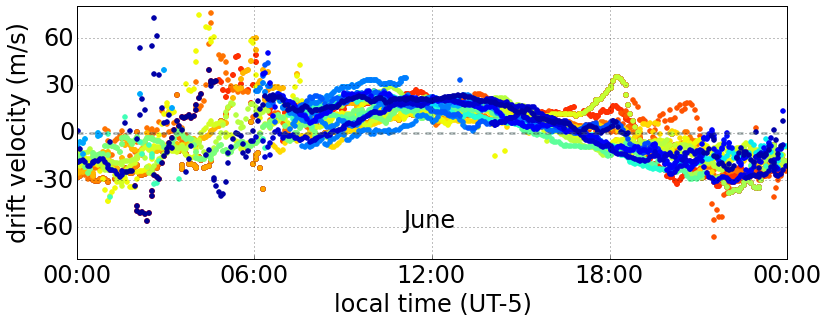

In [107]:
# ave drift plot
mpl.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
# ax.errorbar(unix_time, _image[level, :], _error[level, :], fmt='none', elinewidth=2, capsize=4, 
#                 barsabove=True, ecolor=(.3,.4,.7), color=(.6,.9,.4))
for k, ij in enumerate(_index_breaks):
    i, j = ij
    color = cm.jet_r(k / len(_index_breaks))
    ax.scatter(unix_time[i:j], _image[level, i:j], color=color)
# for i, j in _index_breaks:
#     ax.plot(unix_time[i:j], _image[level, i:j])
# ax.plot(unix_time, _image[level, :], color=(.6,.7,.4,.4))
ax.plot([xticks[0], xticks[-1]], [0, 0], '--', color=(.3,.4,.4,.4), linewidth=3)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_xlim([xticks[0] + xpad[0], xticks[-1] + xpad[-1]])
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.set_ylim(ylim)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
for tic in ax.get_yaxis().get_major_ticks():
    tic.tick1On = tic.tick2On = False
if make_legend:
    ax.legend()
ax.set_xlabel('local time (UT-5)')
# ax.set_xticks([])
ax.set_ylabel('drift velocity (m/s)')
ax.grid(True)
if make_title:
    ax.set_title(title)
ax.text(unix_day_start_offset + 11 * 3600, -60, 'June')
plt.tight_layout()
# ax = ax.twinx()
# ax.set_yticks([])
# ax.set_ylabel('September')
fig.savefig('../figures/june_ensemble_vertical_squashed_no_title.png')

.

.

.

.

.

.

.

.

Anomoly with pre-reversal enhancement on 15 September 2005.

.

.

.

.

.

.

In [ ]:
def get_record_altitudes(data, dtype='GDALT', validate=False):
    '''
    Creates y-axis altitude array from parsed Madrigal HDF5 data

    data -- the data parsed from `parse_madrigal_hdf5`
    dtype -- the data to use for the y axis
    validate -- whether or not to go through the data to check consistency across records
    '''
    altitudes = []
    recnos = data['RECNO']
    indices = recnos == recnos
    altitudes = data[dtype][indices]
    if validate:
        for recno in recnos[1:]:
            indices = recnos == recno
            assert(allzero(data[dtype][indices] - altitudes))
    return altitudes
def get_record_datetimes(data):
    '''
    Creates x-axis datetime list from parsed Madrigal HDF5 data

    data -- the data parsed from `parse_madrigal_hdf5`
    '''
    datetimes = []
    recnos = data['RECNO']
    for recno in recnos:
        i = where(recnos == recno)[0][0]
        year = data['YEAR'][i]
        month = data['MONTH'][i]
        day = data['DAY'][i]
        hour = data['HOUR'][i]
        minute = data['MIN'][i]
        second = data['SEC']
        datetimes.append(datetime.datetime(year, month, day, hour, minute, second))
    return datetimes

In [ ]:
class DriftPlot(object):
    '''
    A matplotlib style ion drift plot.
    '''
    xticks = [200, 4200, 8200]
    yticks = [15, 35, 55]

    def __init__(self, ax, data, **kwargs):
        '''
        ax -- the matplotlib axes on which to plot
        data -- the HDF5 data object
        '''
        # key word args
        for key, item in kwargs.iteritems():
            setattr(self, key, item)
        # drift plot setup
        extent = [numpy.min(data['RECNO']), numpy.max(data['RECNO']),
                  numpy.min(data['GDALT']), numpy.max(data['GDALT'])]
        xtick_labels = ['{hour:02}:{minute:02}'.format(hour=int(data['HOUR'][i]),
                                                       minute=int(data['MIN'][i])) for i in self.xticks]
        ytick_labels = ['{0}'.format(data['GDALT'][i]) for i in self.yticks]
        # drift plot
        divider = make_axes_locatable(ax)
        im = ax.imshow(image, aspect='auto', origin='lower', cmap=cm.RdBu)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        cax = divider.append_axes('right', size='5%', pad=0.55)
        cb = plt.colorbar(im, orientation='vertical', cax=cax)
        cb.set_label('vertical drift', fontsize=13)
        cb.set_clim(-80, 80)
        cb.set_ticks([-100, 0, 100])

In [15]:
# ave drift plot setup


In [9]:
# # create data matrix
# M = len(column_names)
# data_matrix = zeros((N, M))
# for i, column_name in enumerate(column_names):
#     data_matrix[:, i] = data[column_name]
# savemat('test.mat', {'DATA': data})

In [8]:
mpld3.disable_notebook()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['UT1_UNIX'], data['RANGE'])

In [ ]:
from research.septentrio import Septentrio_FileManager, SBF_FileManager, SBF_Parser, SeptentrioDataset
from research.util import TimeWindow

In [35]:
file_manager = SBF_FileManager('/mnt/gluster/by-location/peru/gnsco/polarxs/')
parser = SBF_Parser('/home/breitsbw/data/septentrio_hdf5/config/gps_only.cfg',
                   '/home/breitsbw/projects/sbf-to-hdf5-converter/parse')

filepaths = file_manager.filepaths_during(TimeWindow.one_day_window(datetime.datetime(2013, 3, 12, tzinfo=datetime.timezone.utc)))
infilepath = next(filepaths)
outfilepath = '/home/breitsbw/data/septentrio_hdf5/peru/%s.h5' % basename(infilepath)
print(infilepath, outfilepath)
# parser.parse(infilepath, outfilepath)
dataset = SeptentrioDataset(outfilepath)
dataset.epoch

[(b'YEAR', b'Year (universal time)', 0, b'y', b'Time Related Parameter')
 (b'MONTH', b'Month (universal time)', 0, b'm', b'Time Related Parameter')
 (b'DAY', b'Day (universal time)', 0, b'd', b'Time Related Parameter')
 (b'HOUR', b'Hour (universal time)', 0, b'h', b'Time Related Parameter')
 (b'MIN', b'Minute (universal time)', 0, b'm', b'Time Related Parameter')
 (b'SEC', b'Second (universal time)', 0, b's', b'Time Related Parameter')
 (b'UT1_UNIX', b'Unix seconds (1/1/1970) at start', 0, b's', b'Time Related Parameter')
 (b'UT2_UNIX', b'Unix seconds (1/1/1970) at end', 0, b's', b'Time Related Parameter')
 (b'RECNO', b'Logical Record Number', 0, b'N/A', b'Time Related Parameter')
 (b'GDLATR', b'Reference geod latitude (N hemi=pos)', 0, b'deg', b'Geographic Coordinate')
 (b'GDLONR', b'Reference geodetic longitude', 0, b'deg', b'Geographic Coordinate')
 (b'SPCST', b'Spectral sampling time', 0, b'sec', b'Data Quality Parameter')
 (b'PL', b'Pulse length', 0, b'sec', b'Data Quality Paramet